In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch  

**3.- ¿Gato o Perro?**

**Desarrolle una herramienta de reconocimiento de imágenes que clasifique si una imagen pertenece a un perro o gato.**

**a.- Obtenga el dataset. Acceda a https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P14-Convolutional-Neural-Networks.zip Obtendrá un dataset de 10000 imágenes, 5000 de gatos y 5000 de perros.**

**b.- Importe las librerías a utilizar y divida el dataset en entrenamiento y test (80% y 20%)**

In [0]:
split = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=split)
(raw_train, raw_validation, raw_test), info = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

In [13]:
print(splits)

(NamedSplit('train')(tfds.percent[0:80]), NamedSplit('train')(tfds.percent[80:90]), NamedSplit('train')(tfds.percent[90:100]))


**c.- Construya la CNN con una capa de convolución + RELU + Max. Pool**

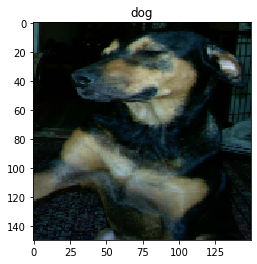

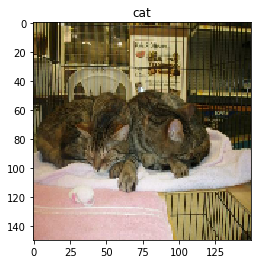

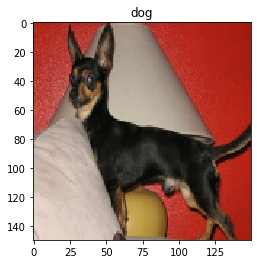

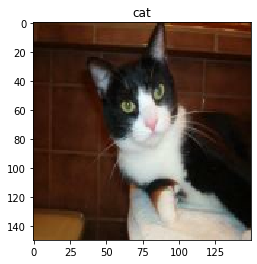

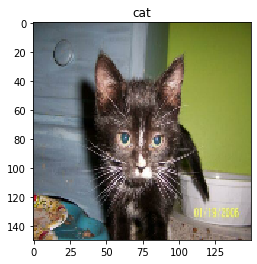

In [14]:
BATCH_SIZE = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150
SHUFFLE_BUFFER_SIZE = 1000

#funcion para redimensionar imagenes
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  return image, label

#aplico redimensionamiento a los datos
train = raw_train.map(format)
validation = raw_validation.map(format)
test = raw_test.map(format)

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)
validation_batches = validation.repeat().batch(SHUFFLE_BUFFER_SIZE)
test_batches = test.batch(SHUFFLE_BUFFER_SIZE)


get_label_name = info.features['label'].int2str
for image, label in train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


**d.- Agregue al Modelo 2 capas completamente conectadas. La primera de 128 neuronas y la Segunda. ¿Cuántas neuronas debería tener?¿Depende de la función de activación que utilicemos?**

La cantidad de neuronas de salida dependera de la funcion de activación a utilizar. Ademas tambien depende del tipo de clasificacion que necesitemos y cantidad de clases a clasificar. Para este caso podemos usar simoid con 1 neurona para clasificacion binaria. O tambien podriamos usar softmax con 2.

In [0]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [16]:
model = Sequential()
#bloque 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               22429824  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,430,849
Trainable params: 22,430,849
Non-trainable params: 0
_________________________________________________________________


**e.- Compile el modelo usando los siguientes parámetros: optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']**

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

**f.- Entrene la Red. Utilice 15 epocas y revise como mejora la accuracy en cada época. Nota este proceso podría tardar un buen tiempo ! (registre el tiempo apróximado de entrenamiento)**

In [18]:
num_train, num_val, num_test = (
  info.splits['train'].num_examples*weight/10
  for weight in split
)

initial_epochs = 15

history = model.fit(train_batches,
                    steps_per_epoch = round(num_train)//BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    validation_steps=10)


Train for 290 steps, validate for 10 steps
Epoch 1/15
290/290 [==============================] - 103s 356ms/step - loss: 0.9940 - accuracy: 0.6469 - val_loss: 0.5596 - val_accuracy: 0.7268
Epoch 2/15
290/290 [==============================] - 103s 355ms/step - loss: 0.4882 - accuracy: 0.7693 - val_loss: 0.5536 - val_accuracy: 0.7316
Epoch 3/15
290/290 [==============================] - 102s 352ms/step - loss: 0.3608 - accuracy: 0.8423 - val_loss: 0.5849 - val_accuracy: 0.7253
Epoch 4/15
290/290 [==============================] - 102s 353ms/step - loss: 0.2533 - accuracy: 0.8982 - val_loss: 0.6163 - val_accuracy: 0.7406
Epoch 5/15
290/290 [==============================] - 102s 353ms/step - loss: 0.1612 - accuracy: 0.9456 - val_loss: 0.7876 - val_accuracy: 0.7508
Epoch 6/15
290/290 [==============================] - 103s 354ms/step - loss: 0.0929 - accuracy: 0.9710 - val_loss: 0.9180 - val_accuracy: 0.7369
Epoch 7/15
290/290 [==============================] - 102s 352ms/step - loss: 0.0

Se trabajo el modelo con loss='binary_crossentropy' ya que brindaba mejores resultados


**g.- Pruebe el modelo**

In [19]:
print(train)
print(test)
print(raw_test)
print(test_batches)

<MapDataset shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


In [33]:
results = model.evaluate(test_batches)

3/3 [==============================] - 7s 2s/step - loss: 1.5972 - accuracy: 0.7547


In [34]:
print('Test loss:', results[0])
print('Test accuracy:', results[1])

Test loss: 1.5972486734390259
Test accuracy: 0.7547414


In [35]:
predictions = model.predict_classes(test_batches, batch_size=None)
print('predictions shape:', predictions.shape)

predictions shape: (2320, 1)


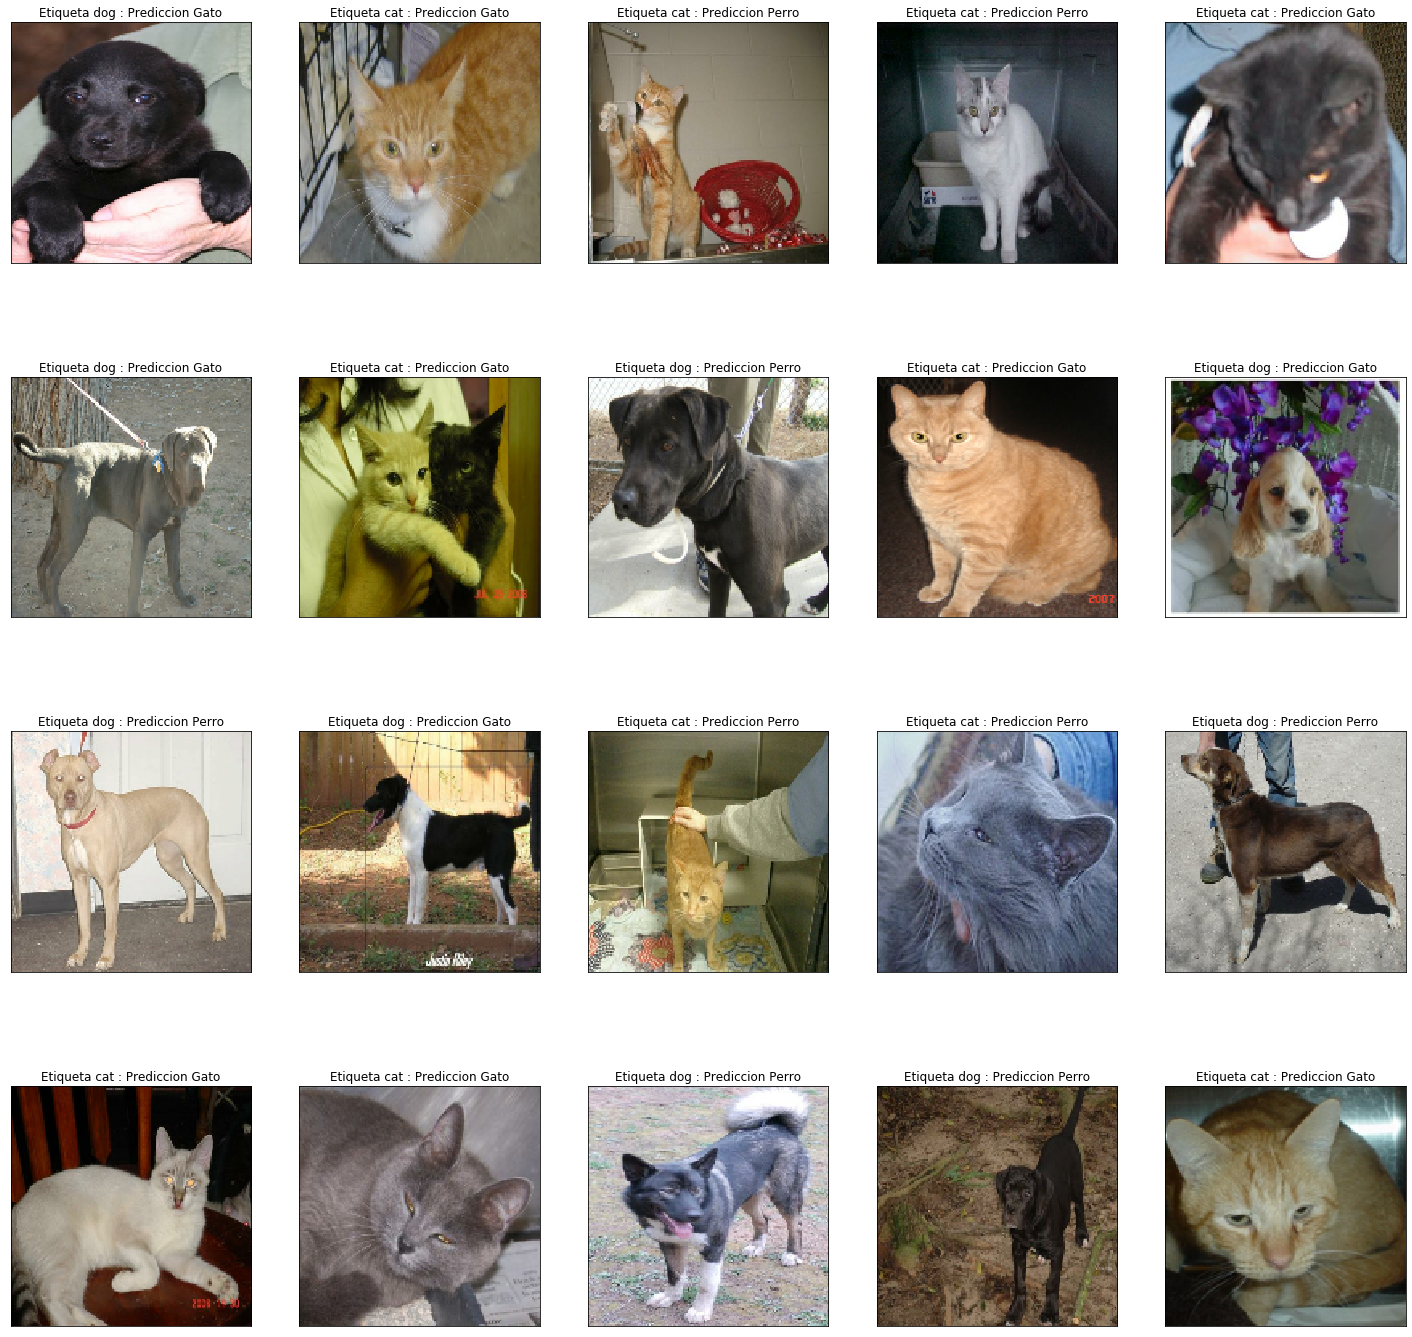

In [36]:
fig, axes = plt.subplots(4, 5, figsize=(25, 25), subplot_kw={'xticks': (), 'yticks': ()}) 
get_label_name = info.features['label'].int2str
classes = {0: 'Gato', 1: 'Perro'}
for image,pred,ax in zip(test.take(20),predictions,axes.ravel()):
  ax.imshow(image[0])
  ax.set_title("Etiqueta {} : Prediccion {}".format(get_label_name(image[1]), classes[pred[0]]))
